### 初始化环境

In [1]:
# 在jupyter notebook里env.render看不到窗口
# 写一个helper类，用matplotlib刷新显示图像
# 初始化传入env，调用helper的render即可
from IPython import display # 导入display模块，用于在Jupyter Notebook中显示图像
import matplotlib
import matplotlib.pyplot as plt # 导入matplotlib库，用于绘制图像
%matplotlib inline

class GymHelper:
    def __init__(self, env, figsize = (3, 3)):
        self.env = env # 初始化Gym环境
        self.figsize = figsize # 初始化绘图窗口大小
        
        plt.figure(figsize = figsize) # 创建绘图窗口
        plt.title(self.env.spec.id) # 标题设为环境名
        self.img = plt.imshow(env.render()) # 在绘图窗口中显示初始图像
    
    def render(self, title = None):
        image_data = self.env.render() # 获取当前环境图像渲染数据
        
        self.img.set_data(image_data) # 更新绘图窗口中的图像数据
        display.display(plt.gcf()) # 刷新显示
        display.clear_output(wait = True) # 有新图片时再清除绘图窗口原有图像
        if title: # 如果有标题，就显示标题
            plt.title(title)

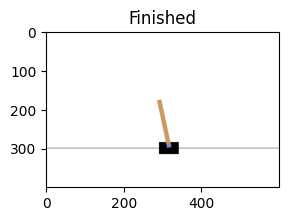

In [2]:
# 导入gym库
import gym

# 创建CartPole环境，指定渲染模式为rgb_array，如果是在IDE中可以改为'human'
env = gym.make('CartPole-v1', render_mode='rgb_array')
# 重置环境
env.reset()
# 创建GymHelper
gym_helper = GymHelper(env)

# 循环N次
for i in range(100):
    gym_helper.render(title = str(i)) # 渲染环境
    action = env.action_space.sample() # 从动作空间中随机选取一个动作
    observation, reward, terminated, truncated, info = env.step(action) # 执行动作
    if terminated or truncated: # 如果游戏结束，则结束循环
        break

# 游戏结束
gym_helper.render(title = "Finished")
# 关闭环境
env.close()

环境介绍 https://www.gymlibrary.dev/environments/classic_control/cart_pole/

### 策略梯度

In [3]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import sys
import time
import random
import collections
from tqdm import * # 用于显示进度条

# 策略模型，给定状态生成各个动作的概率
class PolicyModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyModel, self).__init__()
        
        # 使用全连接层构建一个简单的神经网络，ReLU作为激活函数
        # 最后加一个Softmax层，使得输出可以看作是概率分布
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
        )

    # 定义前向传播，输出动作概率
    def forward(self, x):
        action_prob = torch.sigmoid(self.fc(x)) # 动作空间只有0和1，因此采用sigmoid函数直接输出动作概率
        return action_prob


In [4]:
# 定义Policy Gradient Methods类
class PGM:
    # 构造函数，参数包含环境，学习率，折扣因子，经验回放缓冲区大小，目标网络更新频率
    def __init__(self, env, learning_rate=0.001, gamma=0.99):
        self.env = env
        self.learning_rate = learning_rate
        self.gamma = gamma

        # 判断可用的设备是 CPU 还是 GPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # 定义策略网络
        self.policy_model = PolicyModel(env.observation_space.shape[0], 1).to(self.device)
        # 定义Adam优化器
        self.optimizer = torch.optim.Adam(self.policy_model.parameters(), lr=learning_rate)

    # 使用策略模型生成动作概率分布并采样
    def choose_action(self, state):
        # 将状态转换为tensor输入模型
        state = torch.FloatTensor(np.array([state])).to(self.device)
        probs = self.policy_model(state.to(self.device))
        
        # 生成分布后采样返回动作
        m = torch.distributions.Bernoulli(probs)  # 伯努利分布
        action = int(m.sample().item())  # 转为标量
        return action
    
    # 模型更新
    def update(self, buffer):
        states, actions, rewards, next_states, dones = zip(*buffer)
        states, actions, rewards = list(states), list(actions), list(rewards)
        # 对奖励进行修正，考虑未来，并加入衰减因子
        running_add = 0
        for i in reversed(range(len(rewards))):
            if rewards[i] == 0:
                running_add = 0
            else:
                running_add = running_add * self.gamma + rewards[i]
                rewards[i] = running_add

        reward_mean = np.mean(rewards)  # 求奖励均值
        reward_std = np.std(rewards)  # 求奖励标准差
        for i in range(len(rewards)):
            # 标准化奖励
            rewards[i] = (rewards[i] - reward_mean) / reward_std

        # 梯度下降
        self.optimizer.zero_grad()
        loss = 0  # 初始化损失
        for i in range(len(rewards)):
            state = states[i]
            action = torch.FloatTensor([actions[i]])
            reward = rewards[i]
            state = torch.FloatTensor(np.array([state])).to(self.device)
            action_prob = self.policy_model(state)
            c = torch.distributions.Bernoulli(action_prob)
            # 加权(reward)损失函数，加负号(将最大化问题转化为最小化问题)
            loss = -c.log_prob(action.to(self.device)) * reward
            loss.backward()
        self.optimizer.step()


In [5]:
# 定义超参数
max_episodes = 2000 # 训练episode数
max_steps = 500 # 每个回合的最大步数
# batch_size = 10 # 采样数

# 创建DQN对象
agent = PGM(env)
# 定义保存每个回合奖励的列表
episode_rewards = []

# 开始循环，tqdm用于显示进度条并评估任务时间开销
for episode in tqdm(range(max_episodes), file=sys.stdout):
    # 重置环境并获取初始状态
    state, _ = env.reset()
    # 当前回合的奖励
    episode_reward = 0
    # 记录每个episode的信息
    buffer = []

    # 循环进行每一步操作
    for step in range(max_steps):
        # 根据当前状态选择动作
        action = agent.choose_action(state)
        # 执行动作，获取新的信息
        next_state, reward, terminated, truncated, info = env.step(action)
        # 判断是否达到终止状态
        done = terminated or truncated
        
        # 将这个五元组加到buffer中
        buffer.append((state, action, reward, next_state, done))
        
        # 累计奖励
        episode_reward += reward
        
        # 更新当前状态
        state = next_state
        if done:
            break
        
    # 更新策略
    agent.update(buffer)
    # 记录当前回合奖励值
    episode_rewards.append(episode_reward)

    # 打印中间值
    if episode % (max_episodes // 10) == 0:
        tqdm.write("Episode " + str(episode) + ": " + str(episode_reward))

Episode 0: 24.0                                                                                                        
Episode 200: 460.0                                                                                                     
Episode 400: 410.0                                                                                                     
Episode 600: 179.0                                                                                                     
Episode 800: 96.0                                                                                                      
Episode 1000: 160.0                                                                                                    
Episode 1200: 500.0                                                                                                    
Episode 1400: 379.0                                                                                                    
Episode 1600: 293.0                     

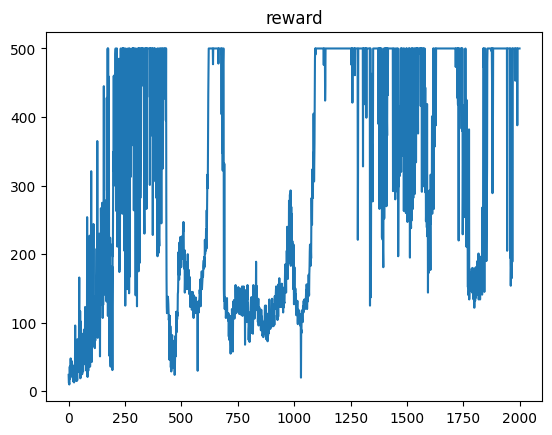

In [7]:
# 使用Matplotlib绘制奖励值的曲线图
plt.plot(episode_rewards)
plt.title("reward")
plt.show()

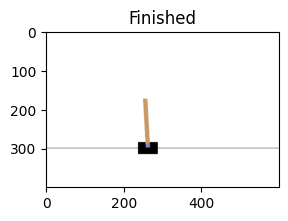

In [8]:
# 重置环境，开始新的一轮游戏
observation, _ = env.reset()
# 创建GymHelper对象来辅助显示
gym_helper = GymHelper(env, figsize = (3, 3))

# 开始游戏
for i in range(700):
    # 渲染环境，title为当前步骤数
    gym_helper.render(title = str(i))
    
    # 通过Q网络找到当前状态下的最优动作
    action = agent.choose_action(observation)
    # 执行action，获取新的信息
    observation, reward, terminated, truncated, info = env.step(action)
    
    # 如果游戏结束，则结束当前循环
    if terminated or truncated:
        break

# 游戏结束
gym_helper.render(title = "Finished")
# 关闭环境
env.close()